In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Define the VAE class containing encoder and Decoder
This part is refer and modified on Iyeoni's design idea. The hyperparameters are tried and modified in the later "Trainer part".

In [10]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [11]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [12]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE + KLD)/bs

In [13]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item() / len(data)))
    train_loss = train_loss / len(train_loader.dataset)
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [14]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))
    return test_loss

# Timer

In [15]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

# Train

In [16]:
from tqdm.notebook import tqdm

EPOCH = 150
train_losses, test_losses = list(), list()
tic()
for epoch in tqdm(range(1, EPOCH+1)):
    train_loss = train(epoch)
    train_losses.append(train_loss)
    test_loss = test()
    test_losses.append(test_loss)
toc()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 Average loss: 1.7809
Test set loss: 1.6067
Epoch: 2 Average loss: 1.5759
Test set loss: 1.5428
Epoch: 3 Average loss: 1.5227
Test set loss: 1.5034
Epoch: 4 Average loss: 1.4910
Test set loss: 1.4791
Epoch: 5 Average loss: 1.4707
Test set loss: 1.4621
Epoch: 6 Average loss: 1.4570
Test set loss: 1.4556
Epoch: 7 Average loss: 1.4475
Test set loss: 1.4452
Epoch: 8 Average loss: 1.4377
Test set loss: 1.4388
Epoch: 9 Average loss: 1.4292
Test set loss: 1.4360
Epoch: 10 Average loss: 1.4237
Test set loss: 1.4285
Epoch: 11 Average loss: 1.4163
Test set loss: 1.4233
Epoch: 12 Average loss: 1.4118
Test set loss: 1.4236
Epoch: 13 Average loss: 1.4066
Test set loss: 1.4174
Epoch: 14 Average loss: 1.4024
Test set loss: 1.4108
Epoch: 15 Average loss: 1.3995
Test set loss: 1.4048
Epoch: 16 Average loss: 1.3936
Test set loss: 1.4037
Epoch: 17 Average loss: 1.3898
Test set loss: 1.4043
Epoch: 18 Average loss: 1.3896
Test set loss: 1.4059
Epoch: 19 Average loss: 1.3855
Test set loss: 1.4033
Ep

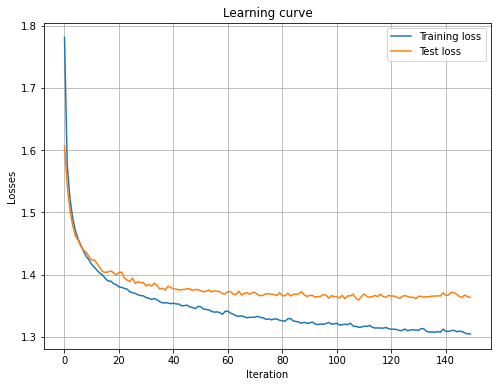

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_losses, '-', label = 'Training loss')
ax.plot(test_losses, '-', label = 'Test loss')

ax.legend()
ax.grid()
ax.set_xlabel('Iteration')
ax.set_ylabel('Losses')
ax.set_title('Learning curve')
plt.show()

In [ ]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    # plt.imshow(sample.view(64, 1, 28, 28))
    save_image(sample.view(64, 1, 28, 28), './sample_' + '.png')

In [ ]:
# path = './tran.pth'
# torch.save(vae.state_dict(), path)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')